# NVIDIA RAPIDS on Azure ML
## GTC 2020 DLI WORKSHOP

In this notebook we use NYC Taxi dataset to showcase some of the speedup and the ease of converting the single-threaded `pandas` execution with GPU-accellerated ETL workload using `cudf` from RAPIDS.

**AUTHORS**
* Tom Drabas (Microsoft)
* Manuel Reyes Gomez (NVIDIA)


**GREATER TEAM**
* Joshua Patterson (NVIDIA)
* Keith Kraus (NVIDIA)
* Brad Rees (NVIDIA)
* John Zedlewski (NVIDIA)
* Paul Mahler (NVIDIA)
* Nick Becker (NVIDIA)
* Michael Beaumont (NVIDIA)
* Chau Dang (NVIDIA)

# Import modules

In [1]:
import os
import cudf
import dask_cudf
import dask
import pandas as pd
import datetime
import time
import numpy as np
from collections import OrderedDict
from math import cos, sin, asin, sqrt, pi

from azureml.core import Run

pd.options.mode.chained_assignment = None 

# Define global vars and methods

In [2]:
columns_dtypes = OrderedDict(
    [
        ('vendor_id', 'int32'),
        ('pickup_datetime', 'date'),
        ('dropoff_datetime', 'date'),
        ('passenger_count', 'int32'),
        ('trip_distance', 'int32'),
        ('pickup_longitude', 'float64'),
        ('pickup_latitude', 'float64'),
        ('rate_code', 'int32'),
        ('store_and_fwd_flag', 'int32'),
        ('dropoff_longitude', 'float64'),
        ('dropoff_latitude', 'float64'),
        ('payment_type', 'int32'),
        ('fare_amount', 'float64'),
        ('extra', 'float64'),
        ('mta_tax', 'float64'),
        ('tip_amount', 'float64'),
        ('tolls_amount', 'float64'),
        ('surcharge', 'float64'),
        ('total_amount', 'float64')
    ]
)

use_col  = [
      'pickup_datetime'
    , 'dropoff_datetime'
    , 'passenger_count'
    , 'trip_distance'
    , 'pickup_longitude'
    , 'pickup_latitude'
    , 'rate_code'
    , 'dropoff_longitude'
    , 'dropoff_latitude'
    , 'fare_amount'
]
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42'
]

In [3]:
def print_message(msg, length=80, filler='#', pre_post=''):
    print(f'{pre_post} {msg} {pre_post}'.center(length, filler))
    
def print_time(t_curr, t_next, t_start, length=80):
    print('> Step time: {0}, elapsed time: {1}'
          .format(str(t_curr - t_next), str(t_curr - t_start)).rjust(length, '-'))
    
def haversine_distance_kernel_gpu(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, h_distance):
    for i, (x_1, y_1, x_2, y_2) in enumerate(zip(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)):
        x_1 = pi / 180 * x_1
        y_1 = pi / 180 * y_1
        x_2 = pi / 180 * x_2
        y_2 = pi / 180 * y_2
        
        dlon = y_2 - y_1
        dlat = x_2 - x_1
        a = sin(dlat / 2)**2 + cos(x_1) * cos(x_2) * sin(dlon / 2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 3959 # Radius of earth in miles
        
        h_distance[i] = c * r
        
def haversine_distance_kernel_cpu(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) 
    
    newlon = lon2 - lon1
    newlat = lat2 - lat1
 
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
 
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 3959 * dist
    return km
    
def add_features(df, gpu):
    df['pickup_datetime'] = df['pickup_datetime'].astype('datetime64[ms]')
    
    df['hour']  = df['pickup_datetime'].dt.hour
    df['year']  = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day']   = df['pickup_datetime'].dt.day
    
    df['pickup_latitude_r']   = (df['pickup_latitude']   / .01).astype('int') / 100.0
    df['pickup_longitude_r']  = (df['pickup_longitude']  / .01).astype('int') / 100.0
    df['dropoff_latitude_r']  = (df['dropoff_latitude']  / .01).astype('int') / 100.0
    df['dropoff_longitude_r'] = (df['dropoff_longitude'] / .01).astype('int') / 100.0
    
    if gpu:
        df = df.drop('pickup_datetime')
        df = df.drop('dropoff_datetime')
        
        df = df.apply_rows(
            haversine_distance_kernel_gpu
            , incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
            , outcols=dict(h_distance=np.float32)
            , kwargs=dict()
        )
    else:
        df = df.drop('pickup_datetime', axis=1)
        df = df.drop('dropoff_datetime', axis=1)
        
        df['h_distance'] = haversine_distance_kernel_cpu(
            df['pickup_latitude']
            , df['pickup_longitude']
            , df['dropoff_latitude']
            , df['dropoff_longitude']
        )
        
    return df



# Define GPU workflow

In [4]:
def bin_fares(fare_amount, fare_bin):
    for i, fare in enumerate(fare_amount):
        fare_bin[i] = int(fare / 10.0) * 10

def run_gpu_workflow(data_path, filename):
    execution_times = []
    t_start = datetime.datetime.now()
    print_message(f'LOADING DATA: {filename}')
    
    taxi_df = cudf.read_csv(
              os.path.join(data_path, filename)
            , names=list(columns_dtypes.keys())
            , dtype=list(columns_dtypes.values())
            , skiprows=1
            , usecols=use_col
        )
    t_next = datetime.datetime.now()
    print_time(t_next, t_start, t_start)
    execution_times.append(('DataReading', t_next-t_start, t_next-t_start))
    
    print()
    print_message('NUMBER OF ROWS: {0:,}'.format(len(taxi_df)), pre_post='+', filler='-')
    print()
    
    print_message('SUBSETTING DATA')
    # apply a list of filter conditions to throw out records with missing or outlier values
    taxi_df = taxi_df.query(' and '.join(query_frags))
    t_curr = datetime.datetime.now()
    print_time(t_curr, t_next, t_start)
    execution_times.append(('DataSubsetting', t_curr-t_next, t_curr-t_start))
    t_next = t_curr
    
    print_message('FEATURIZING DATA')
    taxi_df = add_features(taxi_df, gpu=True)
    t_curr = datetime.datetime.now()
    print_time(t_curr, t_next, t_start)
    execution_times.append(('DataFeaturizing', t_curr-t_next, t_curr-t_start))
    t_next = t_curr
    
    print_message('SORTING DATA')
    taxi_df = taxi_df.sort_values(by='fare_amount')
    t_curr = datetime.datetime.now()
    print_time(t_curr, t_next, t_start)
    execution_times.append(('DataSorting', t_curr-t_next, t_curr-t_start))
    t_next = t_curr
    
    print_message('GROUPING DATA')
    ### PUT THE FARE IN BINS OF $10
    taxi_df = taxi_df.apply_rows(
        bin_fares
        , incols = {'fare_amount': 'fare_amount'}
        , outcols = {'fare_bin': np.int32}
        , kwargs = {}
    )

    taxi_df_fare = taxi_df[['fare_bin', 'passenger_count']].groupby(by='fare_bin').count()
    
    t_curr = datetime.datetime.now()
    print_time(t_curr, t_next, t_start)
    execution_times.append(('DataGrouping', t_curr-t_next, t_curr-t_start))
    
    return taxi_df, taxi_df_fare, t_curr - t_start, execution_times

# Define CPU workflow

In [5]:
def run_cpu_workflow(data_path, filename):
    execution_times = []
    t_start = datetime.datetime.now()
    print_message(f'LOADING DATA: {filename}')
    
    taxi_df = pd.read_csv(
              os.path.join(data_path, filename)
            , names=list(columns_dtypes.keys())
            , parse_dates=True
            , skiprows=2
            , usecols=use_col
        )
    t_next = datetime.datetime.now()
    print_time(t_next, t_start, t_start)
    execution_times.append(('DataReading', t_next-t_start, t_next-t_start))
    
    print()
    print_message('NUMBER OF ROWS: {0:,}'.format(len(taxi_df)), pre_post='+', filler='-')
    print()
    
    print_message('SUBSETTING DATA')
    # apply a list of filter conditions to throw out records with missing or outlier values
    taxi_df = taxi_df.query(' and '.join(query_frags))
    t_curr = datetime.datetime.now()
    print_time(t_curr, t_next, t_start)
    execution_times.append(('DataSubsetting', t_curr-t_next, t_curr-t_start))
    t_next = t_curr
    
    print_message('FEATURIZING DATA')
    taxi_df = add_features(taxi_df, gpu=False)
    t_curr = datetime.datetime.now()
    print_time(t_curr, t_next, t_start)
    execution_times.append(('DataFeaturizing', t_curr-t_next, t_curr-t_start))
    t_next = t_curr
    
    print_message('SORTING DATA')
    taxi_df = taxi_df.sort_values(by='fare_amount')
    t_curr = datetime.datetime.now()
    print_time(t_curr, t_next, t_start)
    execution_times.append(('DataSorting', t_curr-t_next, t_curr-t_start))
    t_next = t_curr
    
    print_message('GROUPING DATA')
    ### PUT THE FARE IN BINS OF $10
    taxi_df['fare_bin'] = taxi_df.apply(lambda row: int(row['fare_amount'] / 10.0) * 10, axis=1)

    taxi_df_fare = taxi_df[['fare_bin', 'passenger_count']].groupby(by='fare_bin').count()
    
    t_curr = datetime.datetime.now()
    print_time(t_curr, t_next, t_start)
    execution_times.append(('DataGrouping', t_curr-t_next, t_curr-t_start))
    
    return taxi_df, taxi_df_fare, t_curr - t_start, execution_times

# Compare the runs

In [6]:
!ls ../../../../../../../datafileshare/data

nyctaxi


In [7]:
data_dir = '../../../../../../../datafileshare/data'     #### REPLACE WITH THE DATA STORE PATH
data_path = os.path.join(data_dir, "nyctaxi")
filename = '2016/yellow_tripdata_2016-06.csv'

In [9]:
gpu_results = run_gpu_workflow(data_path, filename)

################ LOADING DATA: 2016/yellow_tripdata_2016-06.csv ################
-----------------------> Step time: 0:00:01.581051, elapsed time: 0:00:01.581051

-------------------------+ NUMBER OF ROWS: 11,135,470 +-------------------------

############################### SUBSETTING DATA ################################
-----------------------> Step time: 0:00:00.122092, elapsed time: 0:00:01.703143
############################### FEATURIZING DATA ###############################
-----------------------> Step time: 0:00:00.410386, elapsed time: 0:00:02.113529
################################# SORTING DATA #################################
-----------------------> Step time: 0:00:00.306582, elapsed time: 0:00:02.420111
################################ GROUPING DATA #################################
-----------------------> Step time: 0:00:00.146436, elapsed time: 0:00:02.566547


In [10]:
cpu_results = run_cpu_workflow(data_path, filename)

################ LOADING DATA: 2016/yellow_tripdata_2016-06.csv ################
-----------------------> Step time: 0:00:18.137965, elapsed time: 0:00:18.137965

-------------------------+ NUMBER OF ROWS: 11,135,469 +-------------------------

############################### SUBSETTING DATA ################################
-----------------------> Step time: 0:00:00.954297, elapsed time: 0:00:19.092262
############################### FEATURIZING DATA ###############################
-----------------------> Step time: 0:00:08.078235, elapsed time: 0:00:27.170497
################################# SORTING DATA #################################
-----------------------> Step time: 0:00:04.322127, elapsed time: 0:00:31.492624
################################ GROUPING DATA #################################
-----------------------> Step time: 0:02:23.119022, elapsed time: 0:02:54.611646


# Log the results

In [11]:
run = Run.get_context()

### Print the speedups

In [12]:
cpu_runtime = cpu_results[2]
gpu_runtime = gpu_results[2]

print_message('Total CPU time: {0}'.format(str(cpu_runtime)))
print_message('Total GPU time: {0}'.format(str(gpu_runtime)))
print_message('Speedup over CPU: {0:.3f}'.format(cpu_runtime / gpu_runtime))

######################## Total CPU time: 0:02:54.611646 ########################
######################## Total GPU time: 0:00:02.566547 ########################
########################### Speedup over CPU: 68.034 ###########################


### Log the table with times and speedups

In [13]:
results = [(g[0],str(g[1]), str(c[1]), str(g[2]), str(c[2]), c[1] / g[1], c[2] / g[2]) for g,c in zip(gpu_results[3], cpu_results[3])]
results = pd.DataFrame(results, columns=['Step', 'GPU_Step', 'CPU_Step', 'GPU_Elapsed', 'CPU_Elapsed', 'GPU_Step_Speedup', 'GPU_Elapsed_Speedup'])
run.log_table('Single GPU vs CPU comparison', results.to_dict('list'))

### Log the speedup chart

In [14]:
ax = results[['Step', 'GPU_Step_Speedup', 'GPU_Elapsed_Speedup']].plot(x='Step', figsize=(12,9), kind='bar', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() * 1, p.get_height() * 1.3))

run.log_image('Speedup', plot=ax.get_figure())

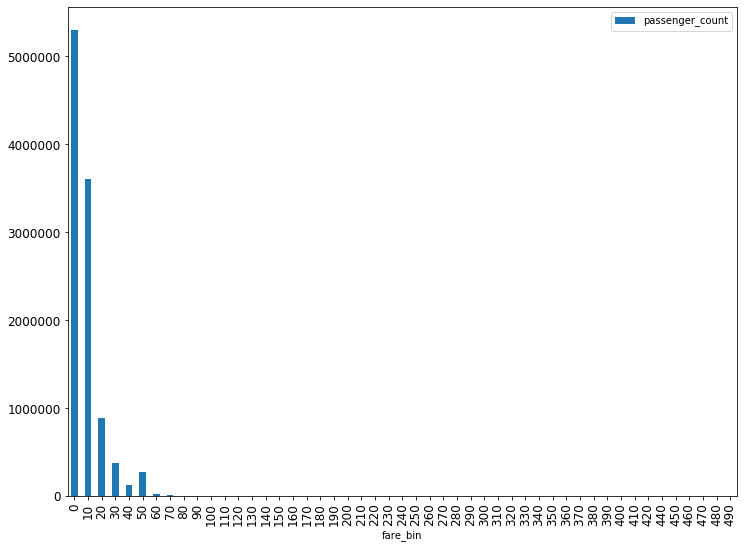

In [22]:
ax = gpu_results[1].to_pandas().plot(figsize=(12,9), kind='bar', fontsize=12)
run.log_image('Fare bin counts June 2016', plot=ax.get_figure())